# **1. Multi-class Classification w/ Custom ResNet model**

⏺ Dataset : CIFAR10

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [5]:
# 런타임 유형 변경 - T4 GPU
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.1+cu121  Device: cuda


In [6]:
BATCH_SIZE = 32
EPOCHS = 10

In [7]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transforms.Compose([
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100%|██████████| 170498071/170498071 [00:03<00:00, 43557819.71it/s]


Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [8]:
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size(), 'type:', X_train.type())
  print('y_train:', y_train.size(), 'type:', y_train.type())
  break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


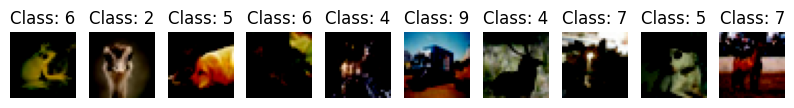

In [9]:
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1,10, i+1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
  plt.title('Class: ' + str(y_train[i].item()))

In [10]:
## Question 1
## Building custom ResNet model

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()   # shortcut을 빈 nn.Sequential로 초기화
        if stride != 1 or in_planes != planes:   # 입력과 출력의 차원이 다르거나, stride 가 1이 아닌 경우에 입출력 텐서를 일치시키기 위한 부분
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
                #  shortcut을 통해서 conv 레이어를 건너뛰어서 출력에 직접 더하는 과정인데, 그 과정이 실행되기 위해서는 차원이 같아야하고
                #  그것을 가능하게 하기 위해서 kernel 사이즈가 1인 conv 레이어를 거치게 됩니다
                nn.BatchNorm2d(planes))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

    # BasicBlock의 구조는 (conv1, bn1, relu), (conv2, bn2), shortcut을 더하고 나서 relu를 취한다.
    #                 in_planes --> planes --> planes --> + shortcut(planes) --> relu

class ResNet(nn.Module):
    def __init__(self, num_classes = 10): # class의 개수는 10개
        super(ResNet, self).__init__()
        self.in_planes = 16 # 입력 차원은 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1) # 16을 받아서 16으로 뱉는데 블록의 개수는 2개이고 첫 블록에서 차원을 줄이지 않는다.
        self.layer2 = self._make_layer(32, 2, stride = 2) # 16를 받아서 32로 뱉는데 블록의 개수는 2개이고 첫 블록에서만 차원을 줄인다.
        self.layer3 = self._make_layer(64, 2, stride = 2) # 32를 받아서 64로 뱉는데 블록의 개수는 2개이고 첫 블록에서만 차원을 줄인다.
        self.linear = nn.Linear(64, num_classes) # 64개 --> num_classes 인 fc

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks  - 1) # num_blocks 만큼 BasicBlock을 생성
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            # 정의된 in_planes와 입력받은 planes, stride에 따라서 BasicBlock을 만든다.
            self.in_planes = planes
            # 다음 블록을 실행하기에 앞서 차원을 맞추어주기 위한 코드
        return nn.Sequential(*layers) # BasicBlock 리스트를 풀어서 Sequential 컨테이너를 결과로 뱉는다.

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8) # average pooling으로 공간적인 차원을 줄이고
        out = out.view(out.size(0), -1) # 그러한 텐서를 flatten한다.
        out = self.linear(out) # 그 flatten된 텐서를 fc에 입력해서 결과를 출력
        return out

    # ResNet의 구조는 (conv1, bn1, relu), layer1(BasicBlock, BasicBlock), layer2(BasicBlock, BasicBlock), layer3(BasicBlock, BasicBlock), fc
    # dim :        3 --> 16 -----------> 16 ----------> 16 ---------> 16 ------------> 32 --------> 32 ---------------> 64 -------> 64 --> num_classes

### Question 1. Explain the code above (building custom ResNet model) in detail -- line-by-line recommended

In [11]:
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [12]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    # image, label, output 모두 텐서의 형태를 가진다.
    loss = criterion(output, label)
    # criterion 메서드는 텐서 연산을 통해서 출력값을 계산하기 때문에 출력값도 텐서의 형태를 가진다.
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
          epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item() # 그래서 이 부분에서 loss tensor를 스칼라만 뽑아서 출력하거나 계산에 활용한다.
      ))

In [13]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [14]:
for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
      epoch, test_loss, test_accuracy)
  )

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.261152
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.571851
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.366132
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 0.971370
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.246575
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 0.989386
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 0.914400
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.065611

[EPOCH: 1], 	Test Loss: 1.0168, 	Test Accuracy: 64.30 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.166110
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.018330
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.735361
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.913107
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.678240
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 0.941087
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.799035
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.962283

[EPOCH: 2], 	Test Loss: 0.8711, 	Test Accuracy: 69.68 % 